### 결측치 분석

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # 데이터 시각화
import missingno as msno  # 결측치 시각화

df = pd.read_csv('netflix.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB
None


<AxesSubplot:>

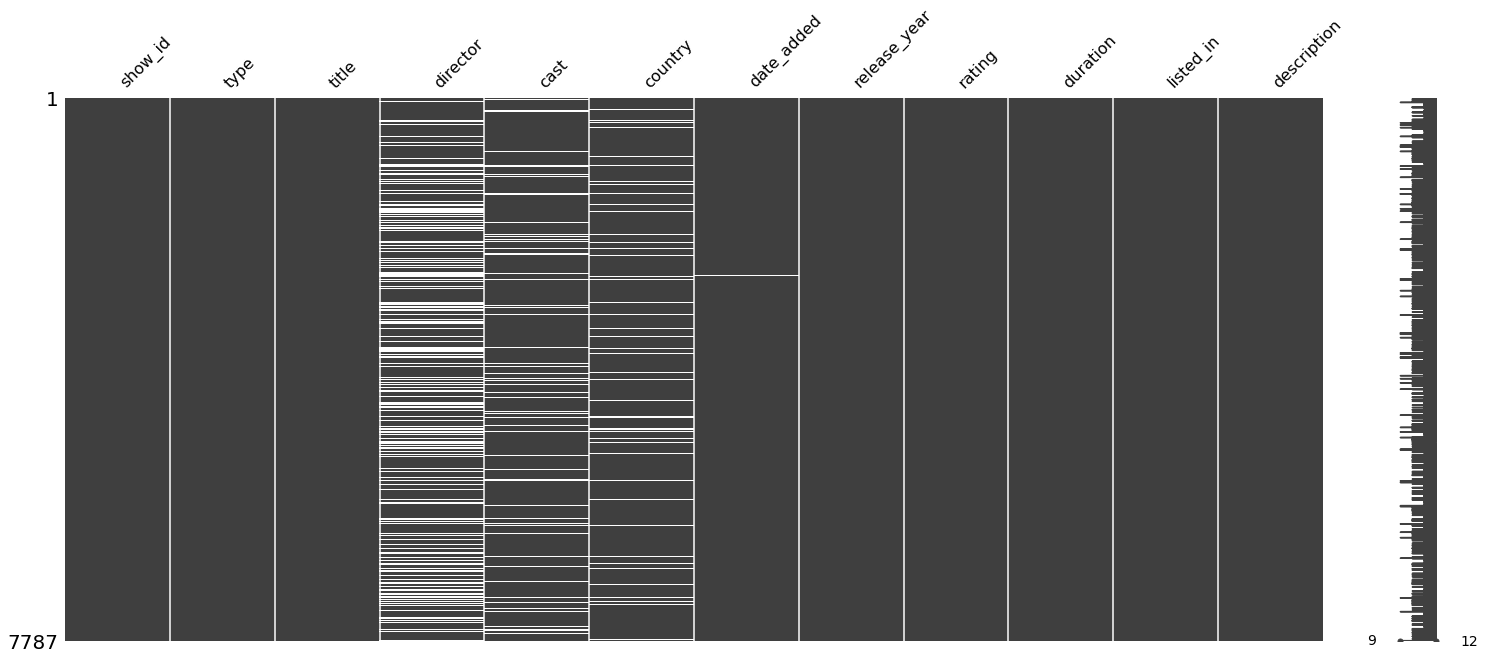

In [2]:
msno.matrix(df)  # 결측치 분포도
# dirctor, cast, country에서 빈 값들이 있다는 것을 알 수 있다.

In [3]:
# 결측치에 대한 비율 - director의 결측치가 가장 큼을 알 수 있다.
for i in df.columns:
    null = df[i].isna().sum() / len(df) * 100
    if null > 0:
        print(f'{i}:{round(null, 2)}%')

director:30.68%
cast:9.22%
country:6.51%
date_added:0.13%
rating:0.09%


### 결측치 보정

In [4]:
# 결측치가 가장 큰 director과 cast 제외하기
df = df.drop(['director', 'cast'], axis=1)
df.columns

Index(['show_id', 'type', 'title', 'country', 'date_added', 'release_year',
       'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

In [5]:
df.isna().sum()  # country, date_added, rating

show_id           0
type              0
title             0
country         507
date_added       10
release_year      0
rating            7
duration          0
listed_in         0
description       0
dtype: int64

In [10]:
# 7개의 rating에 대해서 결측값 채워주기  - 왜 안돼.....

rating_replacements = {
    67: 'TV-PG',
    2359: 'TV-14',
    3660: 'TV-MA',
    3736: 'TV-MA',
    3737: 'NR',
    3738: 'TV-MA',
    4323: 'TV-MA '
}

for num, rate in rating_replacements.items():
    df.iloc[num, 8] = rate
    
df['rating'].isna().sum()

7

In [13]:
# data_added 빈 데이터 row 삭제
df = df[df["date_added"].notna()]

df.isna().sum()

show_id           0
type              0
title             0
country         506
date_added        0
release_year      0
rating            7
duration          0
listed_in         0
description       0
dtype: int64

In [15]:
# 가장 많은 country로 결측치 채우기
df['country'] = df['country'].fillna(df['country'].mode()[0])

df.isna().sum()

show_id         0
type            0
title           0
country         0
date_added      0
release_year    0
rating          7
duration        0
listed_in       0
description     0
dtype: int64

### 결측치 확인 후 시각화

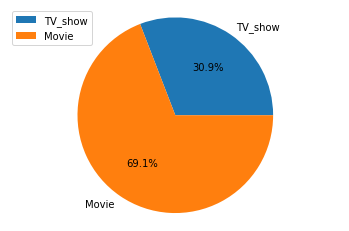

In [16]:
# tv와 movie의 비중
tv_shows = df.groupby('type').count()['title'][1] / len(df)
movies = df.groupby('type').count()['title'][0] / len(df)
plt.pie([tv_shows, movies], labels=['TV_show', 'Movie'], autopct='%.1f%%')
plt.legend()
plt.axis('equal')
plt.show()

In [25]:
# 참고
ratings_ages = { 
    'TV-PG': 'Older Kids', 
    'TV-MA': 'Adults', 
    'TV-Y7-FV': 'Older Kids', 
    'TV-Y7': 'Older Kids', 
    'TV-14': 'Teens', 
    'R': 'Adults', 
    'TV-Y': 'Kids', 
    'NR': 'Adults', 
    'PG-13': 'Teens', 
    'TV-G': 'Kids', 
    'PG': 'Older Kids', 
    'G': 'Kids', 
    'UR': 'Adults', 
    'NC-17': 'Adults' 
}

df['target_ages'] = df['rating'].replace(ratings_ages)
df['target_ages'].unique()
df['target_ages'] = pd.Categorical(df['target_ages'], categories=['Kids', 'Older Kids', 'Teens', 'Adults'])

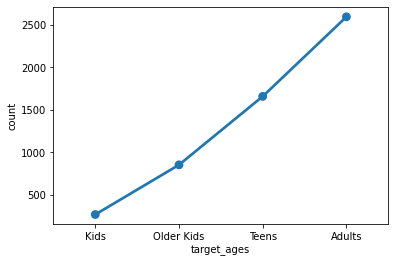

In [26]:
# 영화의 시청 연령별 컨텐츠 수

df_movies = df[df["type"] == "Movie"]
movie_ratings = df_movies.groupby(['target_ages'])['show_id'].count().reset_index(name='count').sort_values(by='count',ascending=False)
sns.pointplot(x='target_ages',y='count',data=movie_ratings)
plt.show()

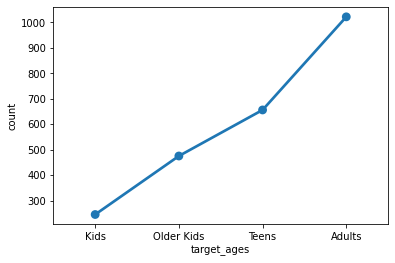

In [33]:
# TV의 시청 연령별 컨텐츠 수

df_tv = df[df["type"] == "TV Show"]
tv_ratings = df_tv.groupby(['target_ages'])['show_id'].count().reset_index(name='count').sort_values(by='count',ascending=False)
sns.pointplot(x='target_ages',y='count',data=tv_ratings)
plt.show()

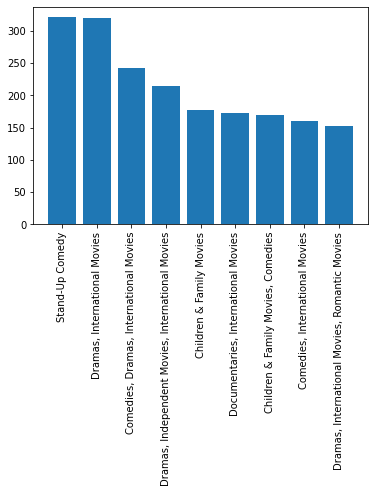

In [47]:
# 영화 장르별 순위

df_movies = df[df["type"] == "Movie"]
genre = df_movies["listed_in"].value_counts().head(10)[1:10]
plt.bar(genre.index, genre)
plt.xticks(rotation=90)
plt.show()

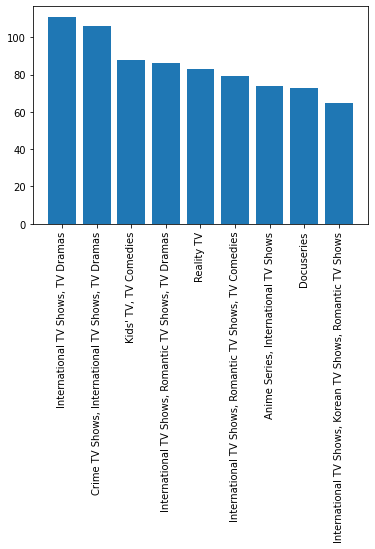

In [49]:
# tv 장르별 순위

df_tv = df[df["type"] == "TV Show"]
genre = df_tv["listed_in"].value_counts().head(10)[1:10]
plt.bar(genre.index, genre)
plt.xticks(rotation=90)
plt.show()

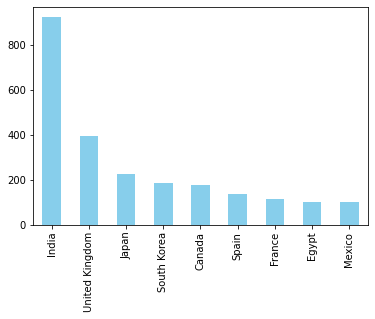

In [50]:
# 결측치 처리 후 컨텐츠 수 상위 10개 나라

df.country.value_counts()[1:10].sort_values(ascending=False).plot(kind='bar', color='skyblue');